# Polarity in C. elegans via PAR proteins 

### Group 1:
#### Members: 

This project is done to explain Anterrior Posterior Symmetry Breaking in C.elegans embroys by the interplay of PAR complexes and cortical flow:

In [120]:
import sys
import os
sys.path.append('ExperimentalData/')

import numpy as np
import scipy as sc
import pickle
import dill
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
dill.dump_session('data/projectPolarity')

In [ ]:
dill.load_session('data/projectPolarity')

### Experimental Data

In [283]:
with open('ExperimentalData/T_PARs.txt','r') as T_PARs:
    time_pars = np.loadtxt(T_PARs)
T_PARs.close()
    
with open('ExperimentalData/X_PARs.txt','r') as X_PARs:
    x_pars = np.loadtxt(X_PARs)
X_PARs.close()

with open('ExperimentalData/PAR6.txt','r') as A_PARs:
    a_pars = np.loadtxt(A_PARs)
A_PARs.close()

with open('ExperimentalData/PAR2.txt','r') as P_PARs:
    p_pars = np.loadtxt(P_PARs)
P_PARs.close()

with open('ExperimentalData/X_flow.txt','r') as X_flow:
    x_flow = np.loadtxt(X_flow)
X_flow.close()
    
with open('ExperimentalData/T_flow.txt','r') as T_flow:
    t_flow = np.loadtxt(T_flow)
T_flow.close()

with open('ExperimentalData/Flow.txt','r') as F_flow:
    f_flow = np.loadtxt(F_flow)
F_flow.close()

#with open("FLOW_INTERP_4077.mat",'r') as int_flow:
    #interp_flow = np.load(int_flow)

from scipy.io import loadmat
interp_mat = loadmat("FLOW_INTERP_4077.mat")['FF_interp']

In [111]:
V_cyto = 2.5*10**4
S_mem = 4.4*10**3
D_a = 0.28
D_p = 0.15
k_offa = 3.24*10**-3
k_offp = 7.19*10**-3
k_ona = 6.29*10**-3
k_onp = 7.682*10**-2
alpha = 2.
beta = 2.
N_a = 2.4*10**5
N_p = 9.8*10**4

### Plotting Experimental data

Text(0.5,1,u'P_PAR')

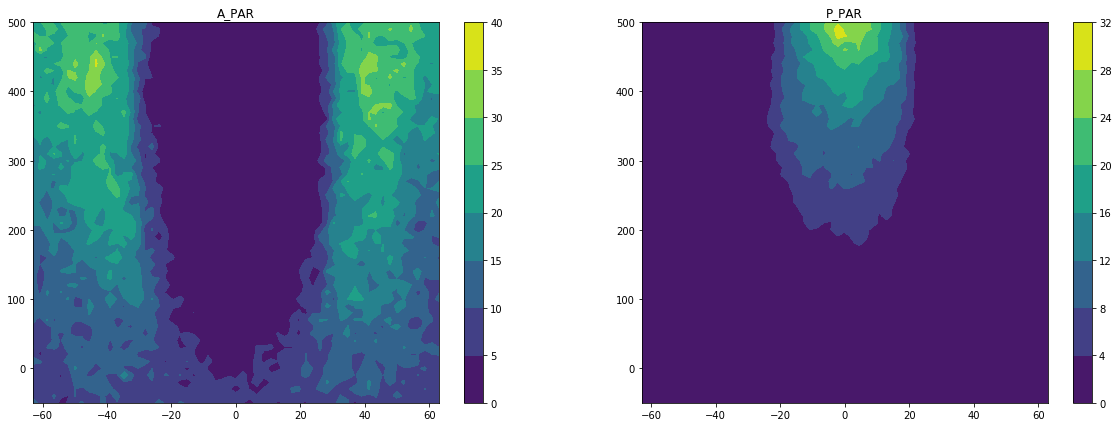

In [112]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.contourf(x_pars,time_pars,a_pars)
plt.colorbar()
plt.title('A_PAR')

plt.subplot(122)
plt.contourf(x_pars,time_pars,p_pars)
plt.colorbar()
plt.title('P_PAR')

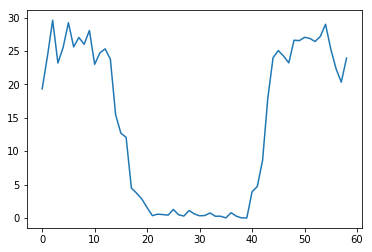

In [275]:
plt.plot(a_pars[-1,:])

In [305]:
np.shape(interp_mat)

(56, 4077)

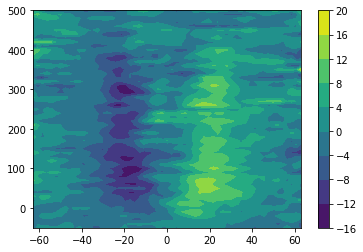

In [53]:
plt.contourf(x_flow,t_flow,f_flow)
plt.colorbar()

In [114]:
a_pars_cyto = (np.ones(np.shape(a_pars))*N_a - a_pars*S_mem)/V_cyto
p_pars_cyto = (np.ones(np.shape(p_pars))*N_p - p_pars*S_mem)/V_cyto

a_pars_pm_total = np.sum(a_pars,axis=1)*S_mem
p_pars_pm_total = np.sum(p_pars,axis=1)*S_mem
a_pars_cyto_total = np.sum(a_pars_cyto,axis=1)*V_cyto
p_pars_cyto_total = np.sum(p_pars_cyto,axis=1)*V_cyto

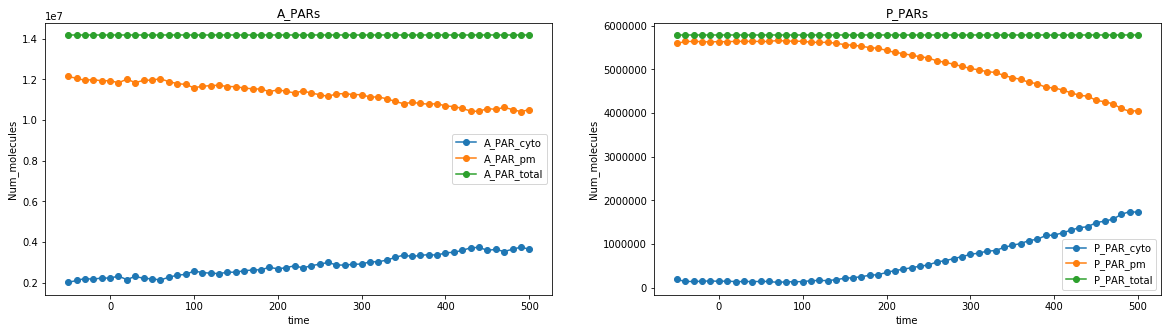

In [115]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(time_pars,a_pars_pm_total,'o-')
plt.plot(time_pars,a_pars_cyto_total,'o-')
plt.plot(time_pars,a_pars_pm_total+a_pars_cyto_total,'o-')
plt.title('A_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['A_PAR_cyto','A_PAR_pm','A_PAR_total'])

plt.subplot(122)
plt.plot(time_pars,p_pars_pm_total,'o-')
plt.plot(time_pars,p_pars_cyto_total,'o-')
plt.plot(time_pars,p_pars_pm_total+p_pars_cyto_total,'o-')
plt.title('P_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['P_PAR_cyto','P_PAR_pm','P_PAR_total'])

## System of equations:

$$ \frac{\partial A(x,t)}{\partial \tau_A} = -k_{offA}' - K_{AP}'A(x,t)P^{\alpha}(x,t) + 1 + D_A'\frac{\partial^2 A(x,t)}{\partial x^2} + A_A'\frac{\partial}{\partial x}A(x,t)v(x,t)$$

$$ \frac{\partial P(x,t)}{\partial \tau_P} = -k_{offP}' - K_{PA}'P(x,t)A^{\beta}(x,t) + 1 + D_P'\frac{\partial^2 P(x,t)}{\partial x^2} + A_P'\frac{\partial}{\partial x}P(x,t)v(x,t)$$

where $$ k_{offA}' = \frac{k_{offA} + \frac{k_{onA}\omega_{membrane}}{V_{cyto}}}{k_{onA}*N_P/V_{cyto}} $$

$$ k_{offP}' = \frac{k_{offP} + \frac{k_{onP}\omega_{membrane}}{V_cyto}}{k_{onA}*N_P/V_{cyto}} $$

$$ K_{AP}' = \frac{K_{AP}}{K_{onA}N_A/V_{cyto}}$$

$$ K_{PA}' = \frac{K_{PA}}{K_{onP}N_P/V_{cyto}}$$

$$ \tau_A = t*k_{onA}N_A/V_{cyto} $$

$$ \tau_P = t*k_{onP}N_P/V_{cyto}$$

$$ D_A' = D_A/k_{onA}N_A/V_{cyto} $$

$$ A_A' = 1/k_{onA}N_A/V_{cyto} $$


### The system:

In [307]:
## Determining the time step:

t_delta = abs(np.round(0.5*2*((x_pars - np.roll(x_pars,1))[1])/(np.max(abs(f_flow))),10))
x_delta = (x_pars - np.roll(x_pars,1))[1]

total_pos = len(x_pars)
int_time  = np.int(np.ceil((time_pars[-1]-time_pars[0])/t_delta))

#Parameters:
par = [k_offa + k_ona*S_mem/V_cyto, k_offp + k_onp*S_mem/V_cyto, k_ona*N_a/V_cyto, k_onp*N_p/V_cyto, 2,2, D_a,D_p]

#Initial Conditions:
x0 = np.zeros([2,len(x_pars)])
x0[0,:] = a_pars[0,:]
x0[1,:] = p_pars[0,:]

# Interploating velocities:

v_interp = np.zeros([int_time,len(x_pars)])
for i in np.arange(len(x_pars)):
    interp_fun = sc.interpolate.interp1d(time_pars,f_flow[:,i],kind='cubic')
    v_interp[:,i] = interp_fun(np.arange(time_pars[0],time_pars[-1],int_time)) 

In [308]:
def systemsolve(x0,v,t_delta,x_delta,total_pos,int_time,parametrs):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    
    def fitsolver(x,*p):
        
        A = np.zeros([total_pos,int_time])
        A[:,0] = x0[0,:]
        P = np.zeros([total_pos,int_time])
        P[:,0] = x0[1,:]

        K_AP   = p[0]
        K_PA   = p[1]

        for i in np.arange(int_time-1):

            A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                       A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                       v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*(x_delta)) + \
                       D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))

            P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                       P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                       v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*(x_delta)) + \
                       D_P*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(2*x_delta**2))
            
        total = np.zeros(2*len(x))

        total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))            

        total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))

        return total
        
    return fitsolver

In [171]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(systemsolve(x0,v_interp.T,t_delta,x_delta,total_pos,int_time,par),time_pars,np.append(a_pars_pm_total,p_pars_pm_total)/S_mem,[0.0001,0.0001])

print popt

/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in add


[ 0.0001  0.0001]


In [309]:
def systemsolve_lq(p,x0,v,t_delta,x_delta,total_pos,int_time,parametrs,x,soln):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    A = np.zeros([total_pos,int_time])
    A[:,0] = x0[0,:]
    P = np.zeros([total_pos,int_time])
    P[:,0] = x0[1,:]

    K_AP   = p[0]
    K_PA   = p[1]

    for i in np.arange(int_time-1):
        
        #print P[:,i]
        
        A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                   A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*x_delta) + \
                   D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

        P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                   P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*x_delta) + \
                   D_P*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))
    
    total = np.zeros(2*len(x))

    total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))            

    total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))
    
    return total-soln

In [311]:
from scipy.optimize import least_squares

soln_lq = least_squares(systemsolve_lq,[.0001,.0001],bounds=[[0,0],[np.inf,np.inf]],args=(x0,v_interp.T,t_delta,x_delta,total_pos,int_time,par,time_pars,np.append(a_pars_pm_total,p_pars_pm_total)/S_mem))

print soln_lq

/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in square
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply


ValueError: Residuals are not finite in the initial point.

In [145]:
def systemsolve_2(x0,v,t_delta,x_delta,total_pos,int_time,parametrs,popt,x):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
        
    A = np.zeros([total_pos,int_time])
    A[:,0] = x0[0,:]
    P = np.zeros([total_pos,int_time])
    P[:,0] = x0[1,:]

    K_AP   = popt[0]
    K_PA   = popt[1]

    for i in np.arange(int_time):

        A[:,i+1] = #A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 + \
                   #-A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) + \
                   #-v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*(x_delta)) + \
                   D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))

        P[:,i+1] = #P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 + \
                   #-P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) + \
                   -v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*(x_delta)) + \
                   D_P*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(2*x_delta**2))

    total = np.zeros(2*len(x))

    total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))            

    total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))

    return total

In [205]:
fit_pars_total = systemsolve_2(x0,f_flow.T,t_delta,x_delta,total_pos,int_time,par,popt,time_pars)

[ 458.22746     0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
   42.174411    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          

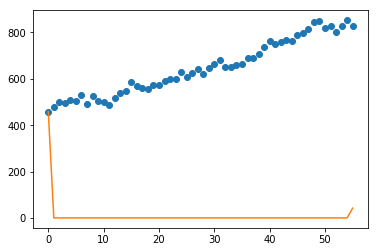

In [149]:
plt.plot(a_pars_pm_total/S_mem,'o')
plt.plot(fit_pars_total[0:len(time_pars)])

$$ A_{x_n}^{t_{n+1}} = \frac{(A_{x_{n-1}}+ A_{x_{n+1}}^{t_n})}{2} + \delta_t(-k_{offA}'A_{x_n}^{t_n} -K_{AP}A_{x_n}^{t_n}(P_{x_n}^{t_n})^2 + c_1 - (v+|v|)\frac{A_{x_n}^{t_n} - A_{x_{n-1}}^{t_n}}{2\delta_x} - (v - |v|)\frac{A_{x_{n+1}}^{t_n} - A_{x_n}^{t_n}}{2\delta_x} + D_A(\frac{A_{x_{n+1}}^{t_n} -2A_{x_n}^{t_n} + A_{x_{n-1}}^{t_n} }{\delta_x^2}) $$

$$  $$